In [6]:
import tqix, constant, base, lagrange_psr
import numpy as np

In [11]:
n = 5
lambdax = 0.05

def H_LMG(h, lambdax, n, Jx, Jy, Jz):
    return -2*h*Jz - 2*lambdax/n*(Jx**2 - Jy**2)

def cost_function(thetas, h):

    qc = tqix.circuit(n)
    for i in range(0, n):
        qc.RX(thetas[i], i)
        qc.RZ(thetas[i + n], i)
        qc.RX(thetas[i + 2 * n], i)
    Jx = qc.Jx()
    Jy = qc.Jy()
    Jz = qc.Jz()
    h_LMG = H_LMG(h, lambdax, n, Jx, Jy, Jz)
    return np.real(np.trace((h_LMG @ qc.state).toarray()))
    
def optimal(h):
    costs = []
    thetass = []
    thetas = np.random.uniform(0, 2*np.pi, n*3)
    for i in range(0, 10):
        print("Iteration: ", i)
        thetass.append(thetas)
        print(thetas)

        thetas = thetas - constant.learning_rate*base.two_prx_hLMG(cost_function, thetas, h)
        costs.append(cost_function(thetas, h))
        print(costs)
    np.savetxt("cost_" + str(h) + ".txt", costs)
    np.savetxt("thetas_" + str(h) + ".txt", thetass)
optimal(0)

Iteration:  0
[4.23975729 0.07615526 1.03110765 2.24787598 1.03657622 2.78807851
 0.73125249 4.64511553 4.29210599 2.46034947 6.08089648 5.09911039
 5.32452528 3.039669   5.98384363]
[0.0375042503841161]
Iteration:  1
[4.2575193  0.0611724  1.01366175 2.2444628  1.05139592 2.77858278
 0.72048565 4.63493011 4.30629346 2.45424105 6.06591363 5.08166449
 5.3211121  3.0544887  5.96406561]
[0.0375042503841161, 0.02300172471746972]
Iteration:  2
[4.27689555 0.04433015 0.99509053 2.23997245 1.06504084 2.77126242
 0.71166432 4.62708099 4.32225283 2.44594894 6.04907137 5.06309327
 5.31662175 3.06813362 5.94484477]
[0.0375042503841161, 0.02300172471746972, 0.009550583422652883]
Iteration:  3
[4.29671753 0.02654796 0.97638273 2.23491177 1.07603588 2.76712925
 0.70591381 4.62271044 4.33933785 2.43580167 6.03128919 5.04438546
 5.31156107 3.07912867 5.92757446]
[0.0375042503841161, 0.02300172471746972, 0.009550583422652883, -0.002124008262693329]
Iteration:  4
[4.31582291 0.00881306 0.95843417 2.2299

In [139]:
hs = np.round(np.arange(-0.1, 0, 0.1), 3)
for h in hs:
    print(h)
    optimal(h)

-0.1


c:\Users\haime\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


-0.05
0


In [2]:
hs = np.round(np.arange(-0.1, 0.1, 0.006), 3)
costs = []
for h in hs:
    cost = np.min(np.loadtxt("cost_" + str(h) + ".txt", dtype=np.complex_))
    costs.append(np.real(cost))

c:\Users\haime\AppData\Local\Programs\Python\Python38\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
c:\Users\haime\AppData\Local\Programs\Python\Python38\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
c:\Users\haime\AppData\Local\Programs\Python\Python38\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


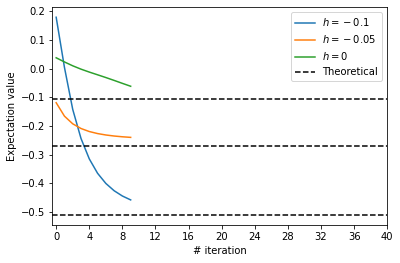

In [12]:
cost1 = np.loadtxt("cost_-0.1.txt", dtype=np.complex_)
cost2 = np.loadtxt("cost_-0.05.txt", dtype=np.complex_)
cost3 = np.loadtxt("cost_0.txt", dtype=np.complex_)
plt.plot(cost1, label = "$h=-0.1$")
plt.axhline(y=-0.10583, color = 'black', linestyle='--')
plt.plot(cost2, label = "$h=-0.05$")
plt.axhline(y=-0.269744, color = 'black', linestyle='--')
plt.plot(cost3, label = "$h=0$")
plt.axhline(y=-0.509973, color = 'black', linestyle='--', label = "Theoretical")
plt.xticks(range(0, 41,4))
plt.xlabel("# iteration")
plt.ylabel("Expectation value")
plt.legend()
plt.savefig("-0.1.-0.05.0.eps", format = 'eps', dpi = 1000)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


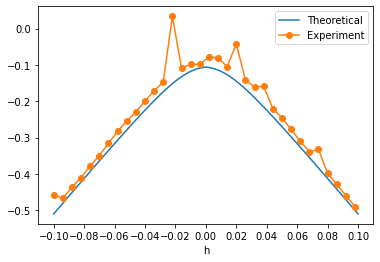

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
cost_theori = pd.read_excel('./image/data.xlsx')
cost_theori = np.array(cost_theori)

plt.plot([d[0] for d in cost_theori], [d[1] for d in cost_theori], label = "Theoretical")
plt.plot(hs, costs, '-o', label = "Experiment")
plt.xticks([-0.1,-0.08,-0.06, -0.04,-0.02,0, 0.02, 0.04, 0.06, 0.08, 0.1])
plt.xlabel("h")
plt.legend()
plt.savefig("compare.eps", format = 'eps', dpi = 1000)

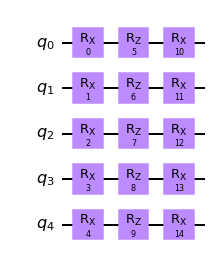

In [10]:
import qiskit
n = 5
thetas = np.zeros(3*n)
for i in range(0, thetas.shape[0]):
    thetas[i] += i
qc = qiskit.QuantumCircuit(n)
for i in range(0, n):
    qc.rx(thetas[i], i)
    qc.rz(thetas[i+n], i)
    qc.rx(thetas[i+2*n], i)
qc.draw('mpl')